<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h1 style="text-align: center;"><b>Детекция бургер-меню мобильных сайтов в телеграмм-боте</b></h1>
Продуктовый трек

### Руководитель проекта:
* Юрий Яровиков (AIRI, МФТИ) | tg:@yu_rovikov

### Проект выполнил:
* Владимир Крылов (МГТУ им.Н.Э.Баумана) | tg:@odmarsib

## План работы

### 1. Поиск проблемы и описание решения

В рамках проекта создаётся телеграмм-бот, позволяющий детектировать элементы (в данной версии пока только бургер-меню) на скриншотах мобильных сайтов.

Это часть сервиса для владельцев и разработчиков сайтов по автоматической оценке удобства пользования вашей или чужой мобильной версией сайта и обнаружению проблем в работе сайта. Финальная версия программы должна автоматически пользоваться сайтом, определяя насколько удобно расположены элементы интерфейса и обнаруживать проблемы в работе сайта.

Сервис должен периодически автоматически пользоваться всем функционалом сайта, оперативно выявляя неработоспособность кнопок, ссылок и прочих элементов, если она есть. При обнаружении неисправностей, владельцу или оператору сайта приходит уведомление с отчётом о проблемах.

В данной работе создаётся минимально рабочий прототип продукта, детектирующий бургер-меню на скриншоте сайта. Полная версия программы потребует для своего создания ресурсы, выходящие за рамки доспутного автору. Алгоритм работы бота следующий:


1.   Бот активируется стартовой командой;
2.   Бот принимает изображение от пользователя (предполагается, что это скриншот мобильной версии сайта, где есть бургер-меню). Изображений может быть несколько;
3.   Бургер-меню детектируется заранее обученной нейросетью и обрамляется красной рамкой;
4.   Изображение с рамкой отправляется пользователю бота;
5.   Пользователь бота получает время исполнения программы;
6.   При необходимости, пользователь может отправить следующие
одно или несколько изображений и получить результат. Время будет рассчитано для всех изображений суммарно.





### 2. Поиск обученной модели и датасета

#### 2.1 Создание датасета

Первоначально, для задачи проекта предполагалось найти в интернете готовый датасет, но такого не было обнаружено. Тогда было принято решение о создании своего. Датасет размещён на GitHub автора  - [по ссылке](https://github.com/Krilaria/Burger_Dataset).

Датасет организован следующим образом:

*   В папке "pics" размещены изображения (скриншоты мобильных версий сайтов), сделанные автором самостоятельно. Файлы имеют расширение .jpg и называются "001", "002" и т.д. Всего в папке 150 изображений.
*   В корне репозитория находятся файлы разметки в формате .csv,
* 1. Train.csv для первых 85 изображений.
* 2. Val.csv для последних 5 изображений (названия с 086 по 090).
* 3. Train_140.csv для первых 140 изображений.
* 4. Val_150.csv  для последних 10 изображений (названия с 141 по 150).

В каждой таблице есть столбцы с названием изображения, координтами размеченных boudung boxes и название класса.

Такая организация связана с расширением датасета по ходу выполнения проекта и необходимостью обучить финальную версию на расширенном датасете, содержащем изображения с новыми признаками (например, меню в центре изображения и большим различием высоты и ширины картинки).


#### 2.2 Поиск модели

Для выполнения проекта была выбрана готовая архитектура FASTERRCNN_RESNET50_FPN.

ResNet50 - это сверточная нейронная сеть, состоящая из 50 слоев. Она предварительно обучена на большом наборе данных ImageNet и используется для извлечения признаков изображений. ResNet50 является основным "спином" модели, который обрабатывает изображение и выделяет его важные особенности.

Feature Pyramid Network (FPN) генерирует множество карт признаков различных масштабов. FPN обрабатывает выходы разных слоев ResNet50 и создает пирамиду карт признаков, где каждый уровень соответствует определенному масштабу объектов. Это позволяет модели обнаруживать объекты на разных размерах и уровнях детализации.

FASTERRCNN_RESNET50_FPN объединяет ResNet50 и FPN вместе. Она использует ResNet50 в качестве "спина" для извлечения признаков и FPN для обработки множества масштабов. Это позволяет модели эффективно и точно обнаруживать объекты на изображениях разных размеров и сложности.

Такое устройство модели позволяет ей быть мощным инструментом для задачи объектной детекции, обеспечивая высокую точность и гибкость в обработке различных типов изображений.


### 2.5. Обучение модели для вашей задачи

Ниже представлен код обучения нейросети. Код будет разбит на логические блоки с комментариями.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops.boxes import nms
from google.colab import drive
drive.mount ('/content/gdrive')

Mounted at /content/gdrive


Импорт библиотек для обучения. Google Drive понадобится для сохранения весов нейросети (объём файла будет более 150 МБ).


---



In [2]:
!git clone https://github.com/Krilaria/Burger_Dataset.git

Cloning into 'Burger_Dataset'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 250 (delta 8), reused 64 (delta 1), pack-reused 160
Receiving objects: 100% (250/250), 21.12 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (26/26), done.


Копирование информации из датасета на GitHub.

---



In [3]:
df_train = pd.read_csv("/content/Burger_Dataset/Train_140.csv",
                       names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])
df_val = pd.read_csv('/content/Burger_Dataset/Val_150.csv',
                    names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])
df_train['bbox'] = df_train[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)
df_val['bbox'] = df_val[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)

df_train['class'] = df_train['class'].map({'burger-menu': 1})
df_val['class'] = df_val['class'].map({'burger-menu': 1})

df_train = df_train.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('filename', as_index=False).agg(list)
df_val = df_val.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('filename', as_index=False).agg(list)

print(f'Число изображений в тренировочной выборке: {df_train["filename"].nunique()}')
print(f'Число изображений в валидационной выборке: {df_val["filename"].nunique()}')

df_train.head()

Число изображений в тренировочной выборке: 140
Число изображений в валидационной выборке: 10


,filename,class,bbox
0,001.jpg,[1],"[[545, 140, 585, 170]]"
1,002.jpg,[1],"[[555, 137, 590, 170]]"
2,003.jpg,[1],"[[547, 140, 590, 170]]"
3,004.jpg,[1],"[[546, 150, 577, 181]]"
4,005.jpg,[1],"[[25, 196, 60, 226]]"


Загрузка данных разметки в датафреймы для тренировочной и валидационной выборки, преобразование информации в них для дальнейшей работы.

---



In [4]:
class MyDataset(Dataset):

    def __init__(self, dataframe, img_path):

        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

Создание класса с описанием методов работы детекции.  Класс позволяет загружать изображения и связанные с ними данные о рамках и метках классов для дальнейшей обработки и обучения модели.

Создание экземпляра класса torch.utils.data.Dataset. В конструктор класса передаётся получившаяся таблица и путь до папки с изображениями. Переопределяются методы __len__ и __getitem__. На выходе класс будет возвращать по индексу изображение в формате torch.tensor и словарь target, в котором будет информация о искомом объекте: координаты рамки и класс.

---



In [5]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Функция, которая будет создавать модель. Исходная модель рассчитана на детекцию 91 класса. В проекте нужно детектировать только один объект, поэтому необходимо заменить box_predictor внутри модели. Меняем количество выходов на 2, потому что нулевым классом должен быть фон.

---



In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

Вспомогательная функция, которая будет применяться к батчам при итерации по torch.utils.data.DataLoader. Она поможет избежать ошибок c размерностями внутри батчей.

---



In [7]:
batch_size = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/Burger_Dataset/pics')
val_dataset = MyDataset(df_val, '/content/Burger_Dataset/pics')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 307MB/s]


Определение размера батча (обусловлен оперативной памятью колаба и тем, что размеры датасетов кратны пяти). Определение устройства, на котором будем обучать модель (CUDA). Создание модели, выбор оптимизатора и регулятора скорости обучения, который каждую эпоху будет уменьшать коэффициент скорости обучения. Были протестированы learning rates 10е-6, 10е-5, 10е-4, 3*10е-4 и 10е-3. Графики лоссов для разных learning rates представлены в папке репозитория автора [по ссылке](https://github.com/Krilaria/Burger_Dataset/tree/main/learning%20rates). В качестве оптимизатора кроме Adam была протестирована SGD, но результаты были сочтены неудовлетворительными. В коде представлены гиперпараметры по результатам экспериментов. Функции потерь уже заданы внутри модели, поэтому нам не нужно их прописывать вручную. Изображения из тренировочной выборки будем перемешивать перед подачей в модель.

---



In [8]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 15 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss

Функции для тренировки и валидации модели. Отличием между ними будет отсутствие расчета градиента при валидации. Внутри функций переводим все данные внутри батча на устройство, на котором будут производится расчеты. Затем, подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную running_loss для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

---



In [9]:
num_epoch = 20

train_losses = []
val_losses = []
try:
    start1 = time.time()
    for epoch in range(num_epoch):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch+1} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch+1}-ю эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    endend = time.time()
    print(f"Всего потрачено {round((endend - start1) / 60, 1)} минут")
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 loss: 1.5497931241989136
	Итерация #15 loss: 0.12033697962760925
Эпоха #1 train_loss: 0.042293516706143106, val_loss: 0.03479956388473511
Потрачено 0.9 минут на 1-ю эпоху
	Итерация #0 loss: 0.10416620969772339
	Итерация #15 loss: 0.2123630791902542
Эпоха #2 train_loss: 0.04811057203582355, val_loss: 0.03813660889863968
Потрачено 0.7 минут на 2-ю эпоху
	Итерация #0 loss: 0.19206590950489044
	Итерация #15 loss: 0.15746939182281494
Эпоха #3 train_loss: 0.032699424720236236, val_loss: 0.03114490807056427
Потрачено 0.7 минут на 3-ю эпоху
	Итерация #0 loss: 0.13700367510318756
	Итерация #15 loss: 0.1011187806725502
Эпоха #4 train_loss: 0.02704714685678482, val_loss: 0.02307571843266487
Потрачено 0.7 минут на 4-ю эпоху
	Итерация #0 loss: 0.3165263235569
	Итерация #15 loss: 0.11885657906532288
Эпоха #5 train_loss: 0.02215968506144626, val_loss: 0.022860601544380188
Потрачено 0.7 минут на 5-ю эпоху
	Итерация #0 loss: 0.0804138332605362
	Итерация #15 loss: 0.06676940619945526
Эпоха 

Создание цикла обучения. Создание двух списков, куда будут сохраняться значения функций потерь после каждой эпохи на тренировке и валидации. Подсчитывается время, затраченное на каждую эпоху и на обучение в целом.

---



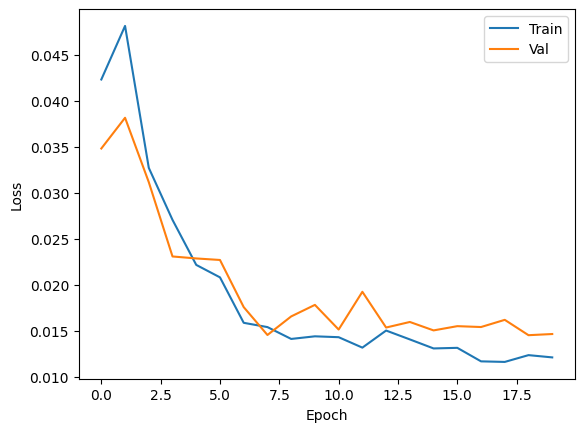

In [10]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

Построение графиков истории обучения модели (лоссы тренировочной и валидационной выборок по эпохам).

---



In [11]:
# 0.1  порог IoU для NMS    0.8 порог для отбора предсказаний
def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=80):
    model.eval() # режим оценки
    # загрузка картинки (указание пути)
    img = cv2.imread(os.path.join('/content/Burger_Dataset/pics', df_val.loc[df_index, 'filename']))
    img_ = img / 255. # normalization
    # img to tensor, изменяется размерность и приводится к float
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_) # получение предсказаний
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy() #
    for i, box in enumerate(predict[0]['boxes'][ind]): #
        if predict[0]['scores'][i] > threshold: #++
            cv2.rectangle(img,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 0, 255), 4)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    cv2_imshow(img)

Функция для применения обученной нейросети. Применение алгоритма non-maximum suppression, который реализован в библиотеке torchvision. Он объединяет похожие рамки на основе их взаимного пересечения.

---



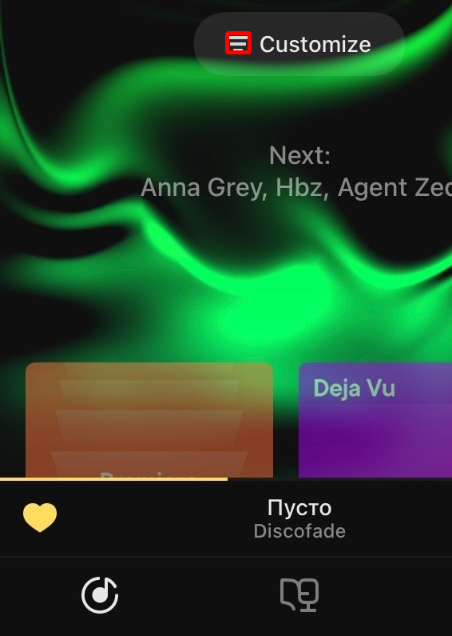

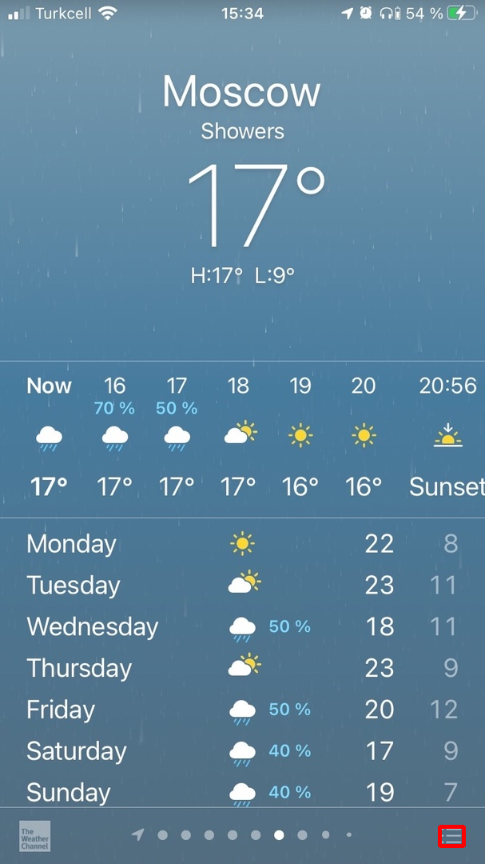

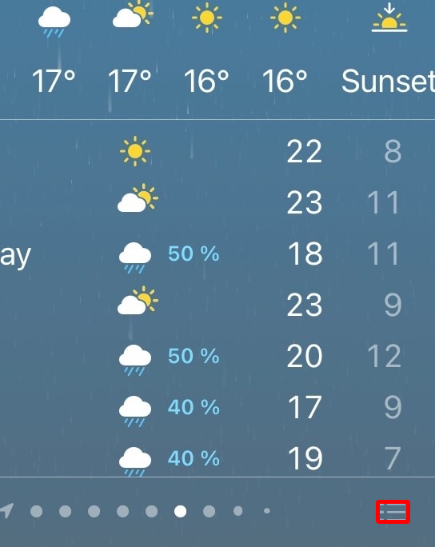

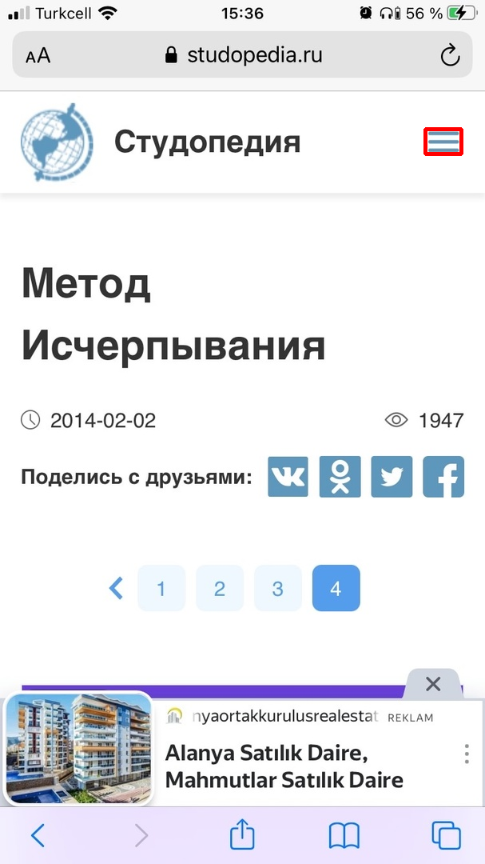

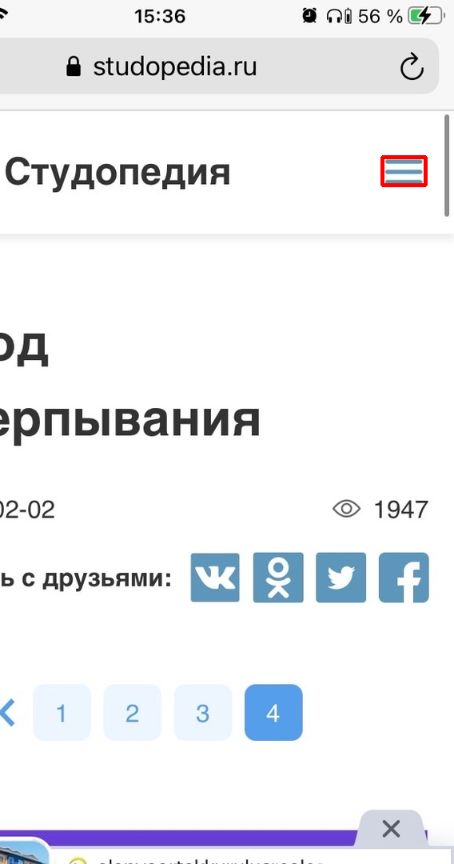

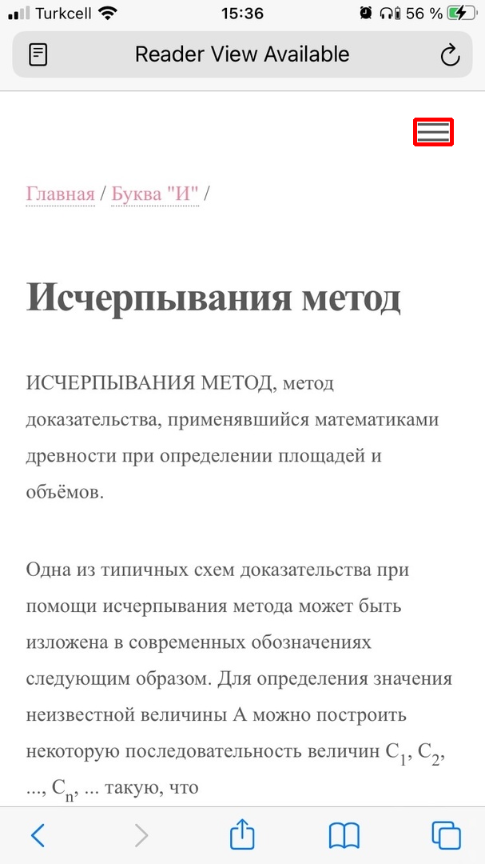

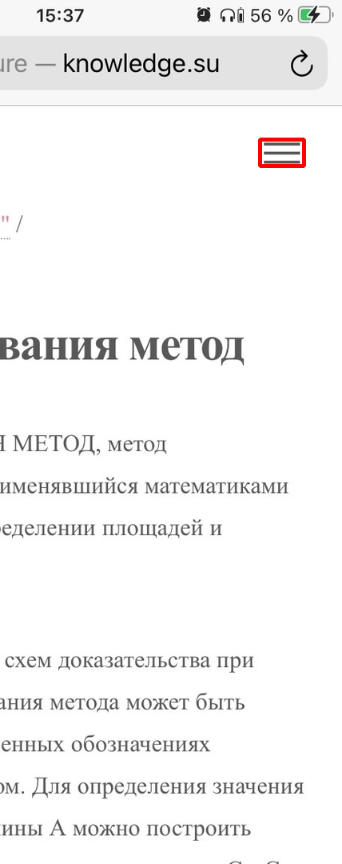

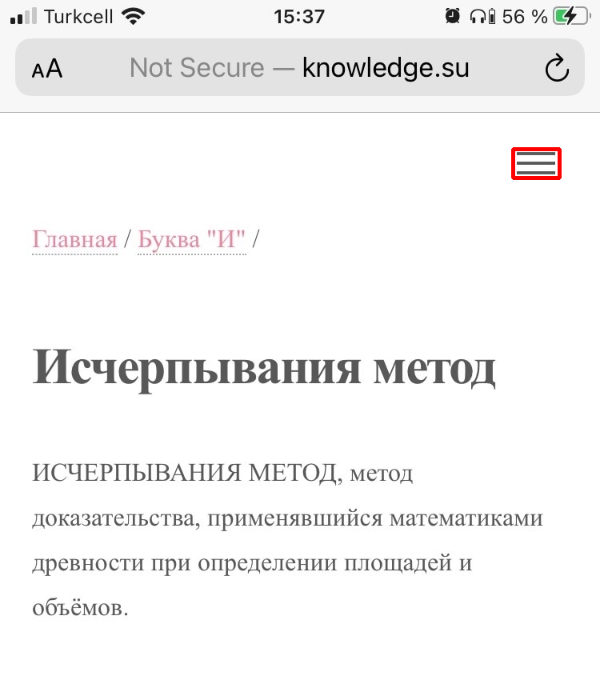

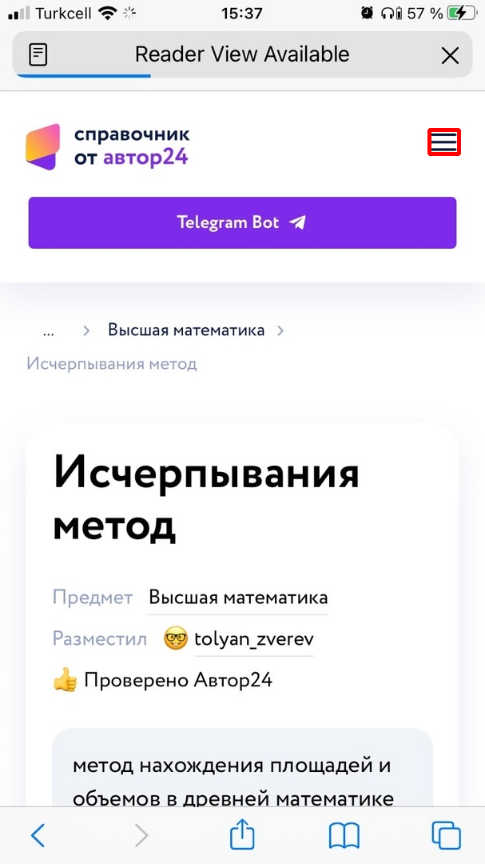

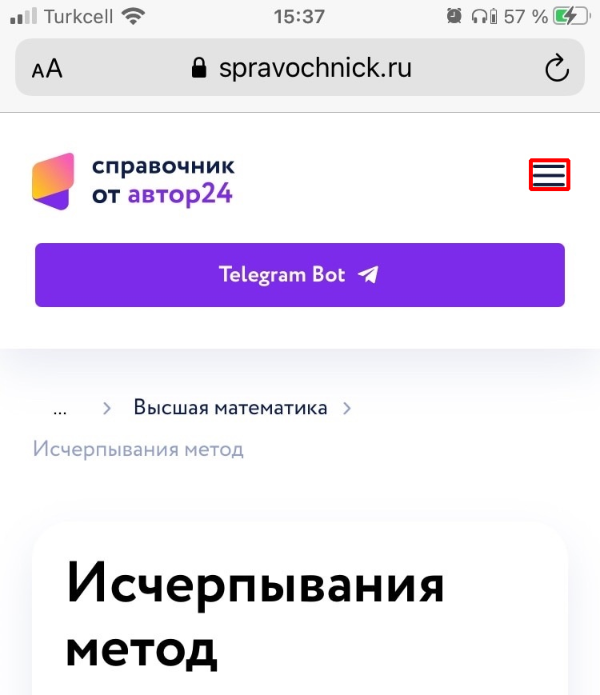

In [12]:
for i in range(len(df_val)):
  draw_predict(i)

Проверка работы нейросети на всей валидационной выборке (10 изображений).

---



In [13]:
weights_dir = '/content/gdrive/MyDrive/Weights_ML/burger_weights_4.pth'
torch.save(model.state_dict(), weights_dir)

Сохранение весов нейросети на Google Drive по указанному пути.

---



### 3. Выбор библиотеки для разработки мобильного демо

Мобильное демо представляет собой телеграмм бота. Для проекта были выбраны библиотеки telebot (для работы команд бота) и webbrowser (для работы со ссылками).

### 4. Разработка демо

Ниже представлен код телеграмм бота. Код будет разбит на логические блоки с комментариями.

In [14]:
pip install pytelegrambotapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.12.0-py3-none-any.whl size=213956 sha256=6d8ec05ed4ddb3ac580779814b294c150007fa49f46cbb1e348dbb2e476b79b2
  Stored in directory: /root/.cache/pip/wheels/7e/ba/82/f3ab5bc48525778633bccc741c0424677ed3435736221819f4
Successfully built pytelegrambotapi


In [15]:
import telebot
import webbrowser
from google.colab import files

Импорт библиотек.

---



In [16]:
bot = telebot.TeleBot('6222820767:AAEvhoK1xOAAVc-UiLouxCpGibvvrslVlVc');

API бота, позволяет управлять ботом через телеграмм канал @botfather и программы.

---



In [17]:
@bot.message_handler(commands=['start'])
def main(message):
    bot.send_message(message.chat.id, "Привет, загрузи скрин сайта с бургер-меню сюда")

@bot.message_handler(commands=['work']) # Распознать
def main(message):
    bot.send_message(message.chat.id, "<em> Загрузите скрин и получите результат </em>", parse_mode = "html")

link = 'https://github.com/Krilaria/Burger_Dataset'

@bot.message_handler(commands=['github'])
def site(message):
    bot.send_message(message.chat.id, "Материалы по проекту " + link)
    webbrowser.open(link)

@bot.message_handler( content_types=['photo'])
def main(message):
    start = time.time()

    # Получение информации о фото
    photo = message.photo[-1]
    file_id = photo.file_id

    # Загрузка файла
    file_info = bot.get_file(file_id)
    file_path = file_info.file_path
    downloaded_file = bot.download_file(file_path)

    # Сохранение файла
    save_path = '/content/start_img.jpg'
    with open(save_path, 'wb') as f:
        f.write(downloaded_file)

    draw_predict(save_path)
    file = open('/content/result_img.jpg', "rb")
    bot.send_photo(message.chat.id, file)
    end = time.time()
    bot.send_message(message.chat.id, f"{round((end - start)*1000)} ms")

#bot.polling(none_stop=True, interval=0)

Код для команд "start", "work", "github" и для действий при отправке пользователем изображений. При отправке фото происходит распознавание бургер-меню и отправка пользователю обработанного изображения, кроме того, подсчитывается время на выполнение программы.

---

### 5. Встраивание модели-детектора в демо

Ниже представлен финальный код для работы бота. Он частично повторяет уже написанное выше, но для удобства код написан в одной ячейке. Бот работает, пока запущена эта ячейка. Для работы важно подключить Google Drive автора работы для доступа к сохранённым при обучении весам модели.

Ссылка на бот: https://t.me/SandwichMenuBot

In [18]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops.boxes import nms

from google.colab import drive
drive.mount ('/content/gdrive')

weights_dir = '/content/gdrive/MyDrive/Weights_ML/burger_weights_4.pth'

def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
map_locationb=torch.device('cpu')
model = create_model(2).to(device)
model.load_state_dict(torch.load(weights_dir))

def draw_predict(save_path, iou_threshold=0.1, threshold=0.8, scale_percent=100):
    model.eval()
    img = cv2.imread(os.path.join(save_path))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 0, 255), 3)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    cv2.imwrite('/content/result_img.jpg', img)

import telebot
import webbrowser
from google.colab import files
bot = telebot.TeleBot('6222820767:AAEvhoK1xOAAVc-UiLouxCpGibvvrslVlVc');

@bot.message_handler(commands=['start'])
def main(message):
    bot.send_message(message.chat.id, "Привет, загрузи скрин сайта с бургер-меню сюда")

@bot.message_handler(commands=['work']) # Распознать
def main(message):
    bot.send_message(message.chat.id, "<em> Загрузите скрин и получите результат </em>", parse_mode = "html")

link = 'https://github.com/Krilaria/Burger_Dataset'

@bot.message_handler(commands=['github'])
def site(message):
    bot.send_message(message.chat.id, "Материалы по проекту " + link)
    webbrowser.open(link)

@bot.message_handler( content_types=['photo'])
def main(message):
    start = time.time()

    # Получение информации о фото
    photo = message.photo[-1]
    file_id = photo.file_id

    # Загрузка файла
    file_info = bot.get_file(file_id)
    file_path = file_info.file_path
    downloaded_file = bot.download_file(file_path)

    # Сохранение файла
    save_path = '/content/start_img.jpg'
    with open(save_path, 'wb') as f:
        f.write(downloaded_file)

    draw_predict(save_path)
    file = open('/content/result_img.jpg', "rb")
    bot.send_photo(message.chat.id, file)
    end = time.time()
    bot.send_message(message.chat.id, f"{round((end - start)*1000)} ms")

bot.polling(none_stop=True, interval=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 6. Тестирование демо

В данном разделе представлены отправленные и полученные изображения через телеграмм-бот. Время, затраченное на их обработку составило 1353 мс, 1523 мс, 1268 мс, 372 мс, 369 мс, 693 мс, 214 мс, 546 мс и 7339 мс соответственно.

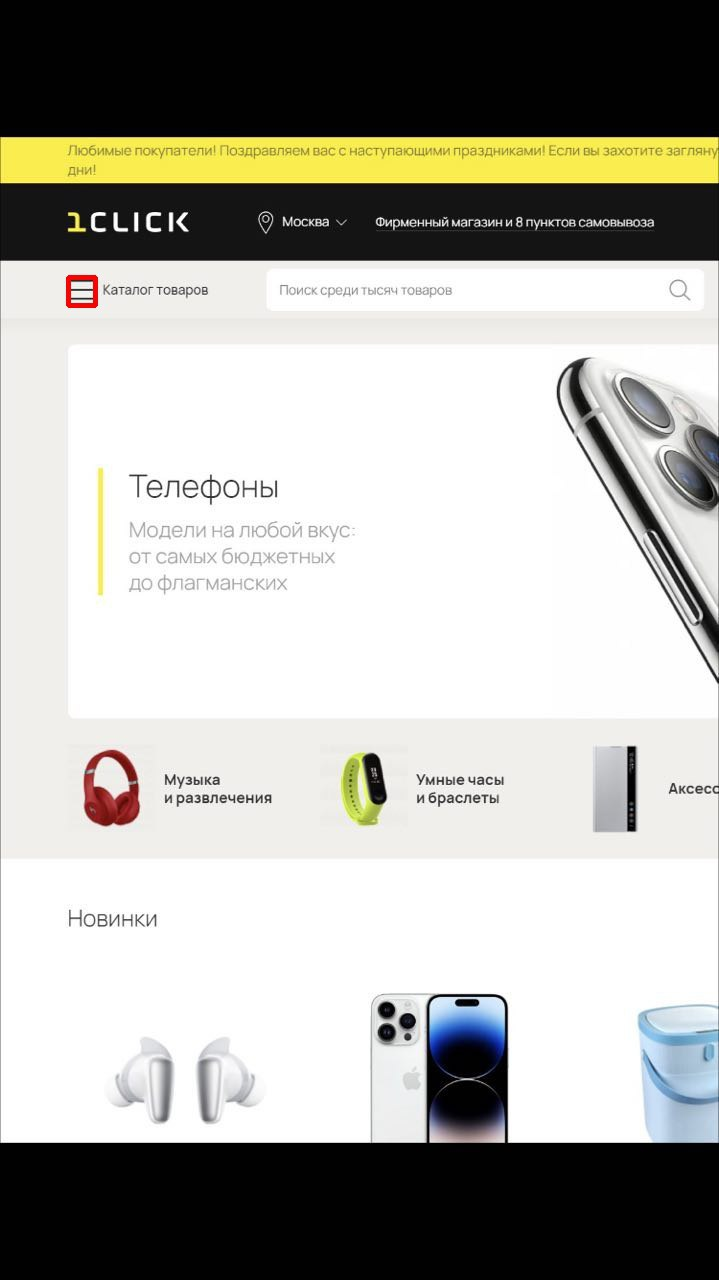


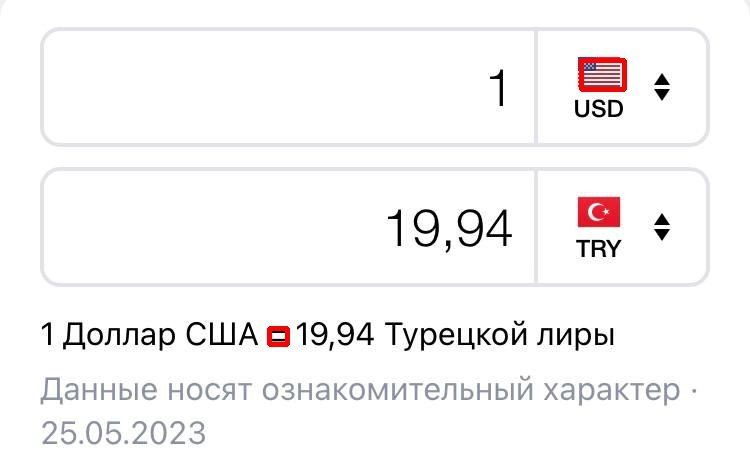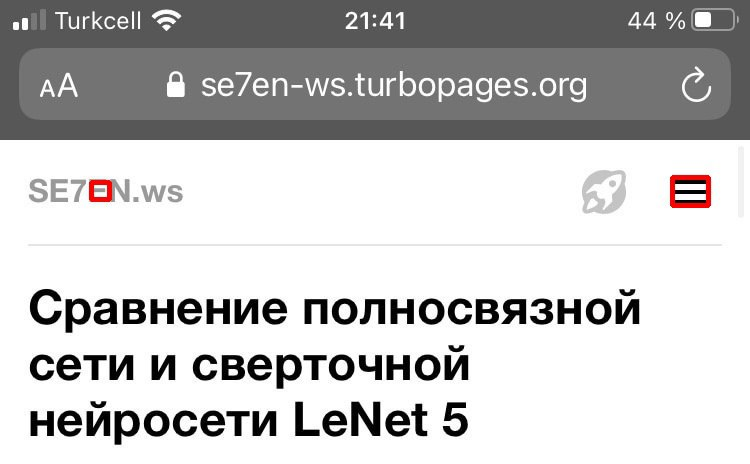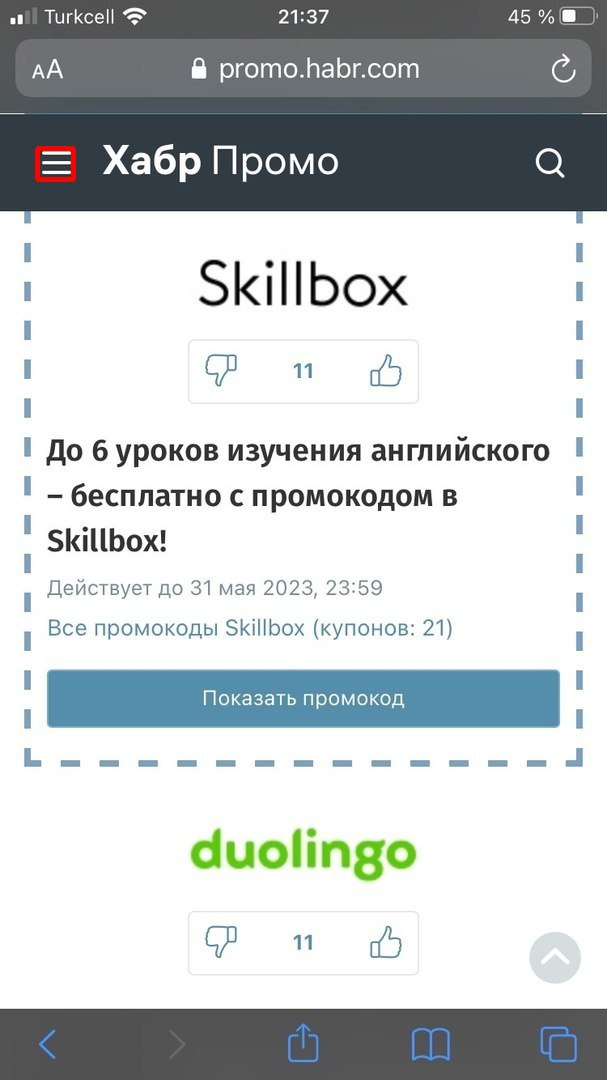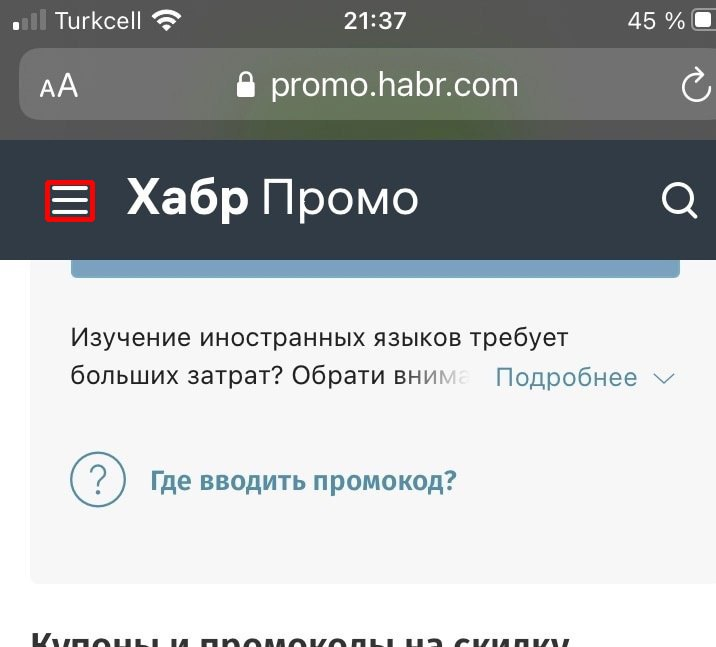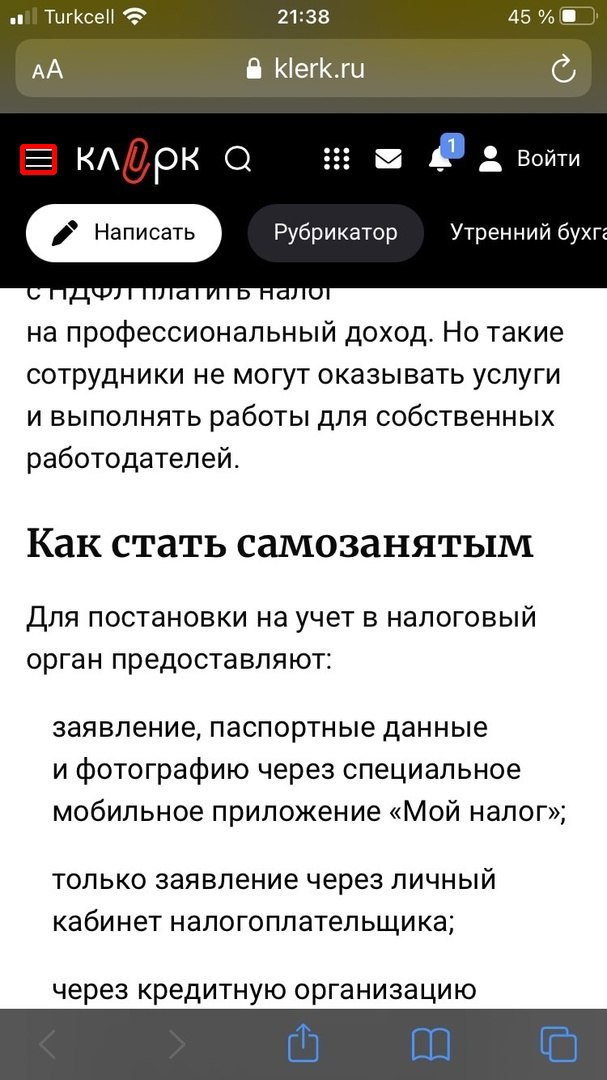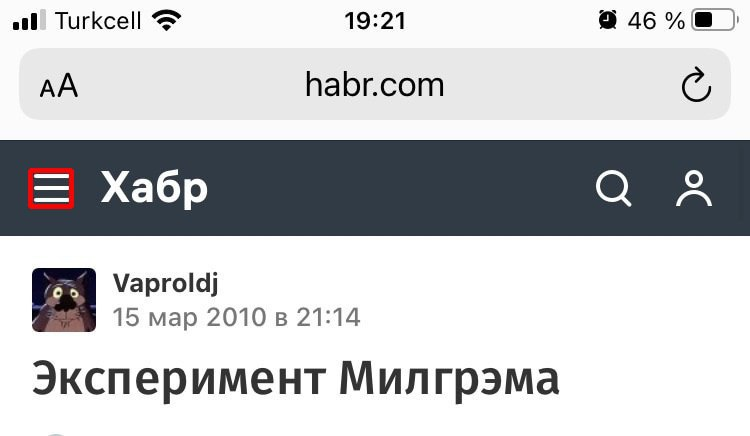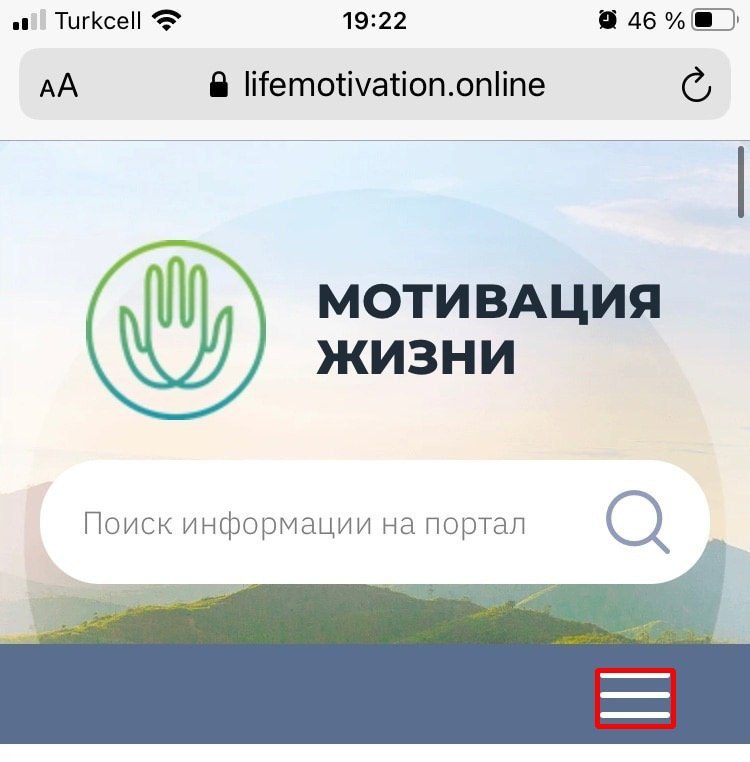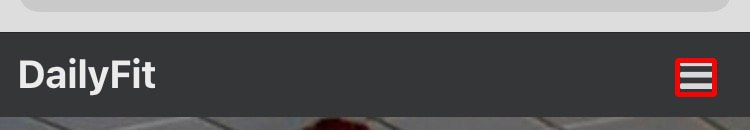

Общие выводы по результатам тестирования демо:

*   Скриншоты сайтов классического дизайна обрабатываются с точностью около 100%;
*   Сильное отличие формы скрина от квадратной мешает детекции объекта;
*   Расположение объекта не в одном из верхних углов мешает детекции объекта;
*   Время обработки сильно зависит от размера изображения;
*   Первая детекция занимает сильно больше времени, чем последующие.

Для улучшения качества работы продукта предлагаются следующие пути: выбор более легковесной модели для ускорения работы, добавление в датасет искажённых изображений для более стабильной работы бота.


### 7. Развертывание демо на сервере

Проект не предполагалось развернуть на сервере и бот работает только когда запущена соответствующая ячейка кода. Для демонстрации работы бота был сделать видеоролик, доступный [по ссылке](https://www.youtube.com/watch?v=tEWpkWmIBmg).

## Заключение

В рамках выпускной работы был разработан телеграмм бот, содержащий нейросетевой детектор, распознающий элемент мобильного сайта. Был создан и размечен датачет, выбрана существующая архитектура, обучена нейросеть, сохнанены веса и написан бот для использования нейросети. Выполнение проекта позволило автору укрепить свои знания и навыки в машинном зрении и работе с кодом.